In [1]:
import nbsetup
import torch
import matplotlib.pyplot as plt
import plot

---

# Fluxes 

In [2]:
import flux

exam = flux.file('I')

F = exam.fluxes("cervi")

for f, k in F:
    print(f'F.{k}:\t[{f[0]:.1f}, {f[1]:.1f}, ..., {f[2]:.1f}]')

F.art:	[2966.7, 2640.2, ..., 2274.8]
F.ven:	[7046.1, 7023.6, ..., 6820.0]
F.csf:	[-981.4, -974.5, ..., -488.3]


### blood and CSF fluxes

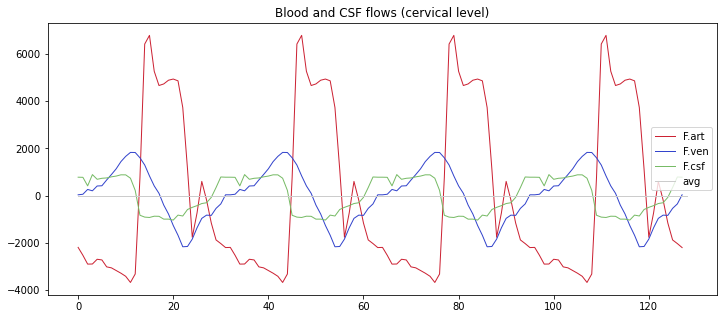

In [3]:
import sig

alpha = F.art.cumsum(dim=0)[-1] / F.ven.cumsum(dim=0)[-1]

F = F.fmap(sig.center(1)).fmap(sig.repeat(4))

lw = {"linewidth": 1}

plt.figure(figsize=(12, 5))
plt.title("Blood and CSF flows (cervical level)")
plt.plot(F.art, color="#c23", **lw, label="F.art")
plt.plot(- F.ven, color="#34c", **lw, label="F.ven")
plt.plot(- alpha * F.csf, color="#7b6", **lw, label="F.csf")
plt.plot([0, F.art.shape[0]], [0, 0], color="#ccc",**lw, label="avg")
plt.legend(loc="right")

### intracranial volume change

The total volume of arterial blood $V_{tot}$ flowing into the brain through a cardiac cycle is assumed to be faithfully represented by the time integral: 

$$ V_{tot} = \int_0^1 F_{art}(t) \: dt $$

The venous outflow is however more sparsely distributed and not fully captured by the segmentation on venous regions of interests. Enforcing blood volume conservation over the typical cardiac, we assume the real venous outflow proportional to the measured flow $F_{ven}(t)$ by a factor $\alpha = \frac 1 {V_{tot}} \int_0^1 F_{ven}(t)\, dt $.

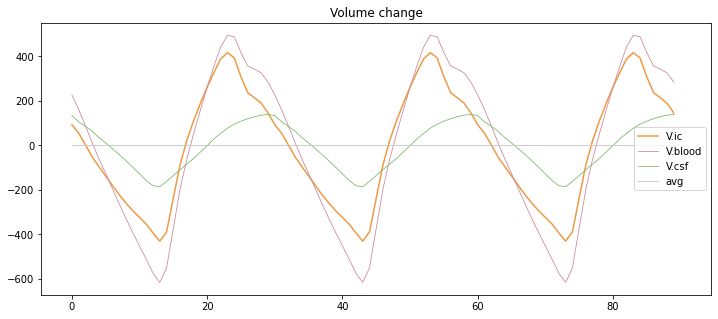

In [4]:
V = exam.volumes("cervi")\
    .fmap(sig.center(1))\
    .fmap(lambda t: t[:-1])\
    .fmap(sig.repeat(3))
    

plt.figure(figsize=(12, 5))
plt.plot(V.ic, color="#e94", linewidth=1.5, label="V.ic")
plt.plot(V.blood, color="#c89", linewidth=0.8, label="V.blood")
plt.plot(V.csf, color="#7b6", linewidth=0.8, label="V.csf")
plt.plot([0, V.art.shape[0]], [0, 0], color="#ccc",**lw, label="avg")
plt.title("Volume change")
plt.legend(loc="right")

The intracranial volume change is the source of pressure oscillations, and should have the same shape as ICP up to compliance, $dV = C\: dP$  with compliance $C$ almost constant in the linear regime of small amplitude cardiac oscillations. 

### multivariate signal

This data is very interesting because it records fluxes of different nature accross multiple channels. 

Therefore we can analyse the interaction between different components of the signal to extract information on the underlying dynamics. This can be done either in the spectral domain (transfer functions) or in the temporal domain (jets / phase diagrams).

Temporal methods are more suited for non-linear systems. 

---

# ICP 

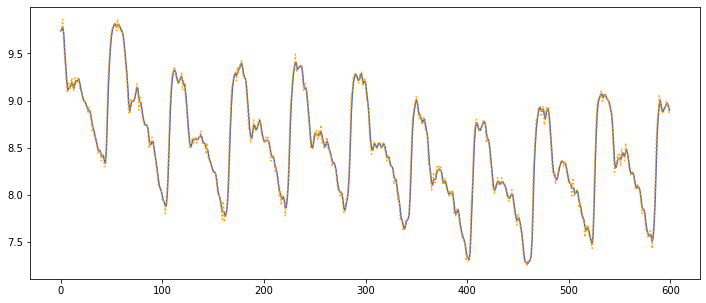

In [5]:
import icp
f = icp.file(0)
p_raw = f.icp(600)
p = sig.heat(0.8)(p_raw)

plt.figure(figsize=(12, 5))
plt.plot(p, color="#56a")
plt.plot(p_raw, color="orange", linestyle="dotted")

The signal is denoised by applying short-range gaussian kernels

### segmentation and pulse extraction

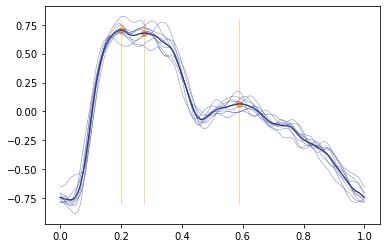

In [6]:
import sig

# Heat regularisation
p = sig.heat(0.8)(p_raw)

# Segmentation on deeper troughs
segs = sig.segments(p, heat=(6, 2.5))

# Cubic resampling 
segs = [(sig.resample(s, 120)) for s in segs]

# Center up to 2nd derivative
segs = [sig.center(2)(s) for s in segs]

# Pulse average 
pulse = torch.stack(segs).sum(dim=[0]) / len(segs)

for s in segs: 
    t = torch.linspace(0, 1, s.shape[0])
    plt.plot(t, s, color="#56a", linewidth=0.4)

plt.plot(torch.linspace(0, 1, pulse.shape[0]), pulse, linewidth=1.3, color="#338")
plot.peaks(torch.linspace(0, 1, pulse.shape[0]), pulse, yrange=(-0.8, 0.8), color="#fa4")

### phase diagrams

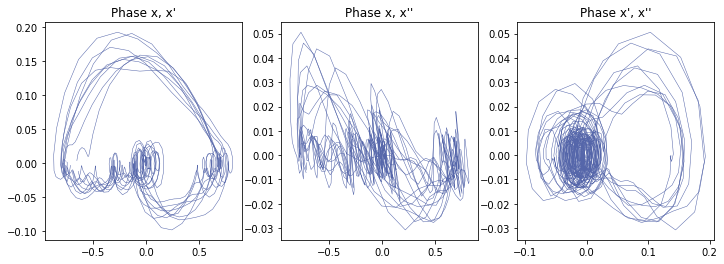

In [9]:
segs_reg = [sig.heat(1)(s) for s in segs]

def diff(x): 
    d1 = torch.cat([torch.diff(x), torch.tensor([0.])])
    d2 = torch.cat([torch.tensor([0.]), torch.diff(x)])
    return (d1 + d2) / 2

def diff2(x):
    return diff(diff(x))


""" Plot phase diagrams """
plt.figure(figsize=(12, 4))

style = {"linewidth": 0.5, "color": "#56a"}
plt.subplot(1, 3, 1)
plt.title("Phase x, x'")
for s in segs_reg:
    plt.plot(s, diff(s), **style)
# plt.plot(pulse, diff(pulse), linewidth=1, color="#338")

plt.subplot(1, 3, 2)
plt.title("Phase x, x''")
for s in segs_reg:
    plt.plot(s, diff2(s), **style)
# plt.plot(pulse, diff2(pulse), linewidth=1, color="#338")

plt.subplot(1, 3, 3)
plt.title("Phase x', x''")
for s in segs_reg:
    plt.plot(diff(s), diff2(s), **style)
# plt.plot(diff(pulse), diff2(pulse), linewidth=1, color="#338")


We may plot the second order phase diagram $x, x', x''$ of a curve $x(t)$ in 3 dimensions:

<img width="300px" src="img/phase2.jpg" alt="[3D phase diagram]">

### relation with dynamics

For a linear 2nd order dynamical system $ x'' + a x' + b x =  0 $, the second order phase diagram $(x, x', x'')$ lies inside the vectorial plane defined by the associated cartesian equation. 

In general, we may always write a (non-linear) 2nd order differential equation as: 

$$ x'' + a x' + b x = f(x, x', t) $$ 

Where $f$ is a force term that may eventually depend over time. Given a choice of metric on $f$ we may look for optimal $(a, b)$ and infer some sort of underlying "average" dynamical features on the system. 

- $a$: damping of oscillations 
- $b$: stiffness, related to compliance

Here $f$ could describe the effect of flows on intracranial volume expansion. The stiffness $b$ should also appear in the power spectrum of $x$, as frequency of spontaneous oscillations during relaxation. 


### flux + icp

The fluxes at different levels hold information on the exterior forces acting on ICP, as they are temporally coherent with pressure gradients putting the blood in motion. 

Note the frequency of spontaneous oscillations in the ICP signal seem higher than the MRI sampling frequency / not precisely detectable through the CC averaging process. 

---

# ML

### self-supervised learning

We could design self-supervised tasks to pretrain a network and develop a good representation of pulse space.

$$ \mathcal{X} \overset{g_\theta}{\longrightarrow} \mathcal{Y} $$ 

As input to the neural network we could feed derivatives, i.e. an N-dimensional phase diagram, together with the signal. That way the network (RNN, LSTM...) can naturally learn (non-linear) relations between derivatives.

This would translate in the architecture of $g_\theta$.

### downstream tasks

Usually the representation $g_\theta: \mathcal{X} \to \mathcal{Y}$ is learned to prepare for _downstream_ tasks 
$h_{\theta'} : \mathcal{Y} \to \mathcal{Z}$. 

The relevance of $g_\theta : \mathcal{X} \to \mathcal{Y}$ is assessed in the success of downstream tasks on low volume datasets.

We also need to have downstream tasks in mind or at hand to iterate on the architecture of $g_\theta$ and improve the self-learned representation. 